In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import matplotlib.pyplot as plt
import json
import h5py
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

def load_data(src):
    with h5py.File(src, "r") as f:
        keys = list(f.keys())
        raw = f[keys[0]][:]  

    # Convert to text
    text = raw.tobytes().decode("utf-8")

    # Load as json
    data_json = json.loads(text)

    df = pd.DataFrame(data_json)

    return df

def calculate_metrics(df):

    # Convert values to float
    df["time"] = df["time"].astype(float)
    df["voltage"] = df["voltage"].astype(float)
    df["current"] = df["current"].astype(float)

    # Identify changes in status to segment the data
    df.loc[:, "state_change"] = (df["State"] != df["State"].shift()).cumsum()

    # Group by status change segments
    grouped = df.groupby("state_change")

    results = []

    for _, g in grouped:
        subset = g.iloc[1:-1]

        if subset.empty or subset["State"].isna().all():
            continue

        # Metrics
        status = subset["State"].iloc[0]
        start_time = subset["time"].iloc[0]
        end_time = subset["time"].iloc[-1]
        duration = end_time - start_time

        avg_current = subset["current"].mean()
        std_current = subset["current"].std()

        avg_tension = subset["voltage"].mean()
        std_tension = subset["voltage"].std()

        results.append({
            "status": status,
            "start_time": start_time,
            "end_time": end_time,
            "duration": duration,
            "avg_current": avg_current,
            "std_current": std_current,
            "avg_tension": avg_tension,
            "std_tension": std_tension
        })

    # Store metrics in results
    results = pd.DataFrame(results)

    return results

def create_df():
    src = "../../../../../../media/mods-pred/Datasets/Data_uconn_h5"
    checkups_paths = []

    # Get all checkup paths
    for cell in sorted(os.listdir(src)):
        cell_path = os.path.join(src, cell)
        for file in sorted(os.listdir(cell_path)):
            if "CHECKUP" in file:
                checkups_paths.append(os.path.join(cell_path, file))

    all_cycles = [] # Contains the features of each cycle

    for checkup in checkups_paths:
        # Load checkup data
        df = load_data(checkup)
        
        # Create metrics table
        results = calculate_metrics(df)

        # Separate features by group
        features = {}
        for status_name, group in results.groupby("status"):
            features[f"{status_name}_avg_current"] = group["avg_current"].mean()
            features[f"{status_name}_std_current"] = group["std_current"].mean()
            features[f"{status_name}_avg_tension"] = group["avg_tension"].mean()
            features[f"{status_name}_std_tension"] = group["std_tension"].mean()
            #features[f"{status_name}_duration"] = group["duration"].sum()

        # Calculate real SoH (nominal capacity = 1.2 Ah)
        features["SoH"] = max(df["capacity"].astype(float)) * 100 / 1.2

        # Store cell id
        features["cell_id"] = os.path.basename(os.path.dirname(checkup))

        # Add features to all_cycles array
        all_cycles.append(features)

    # Create final df
    df = pd.DataFrame(all_cycles).fillna(0)

    return df

def RF_full_plot(y_test, y_pred_rf):

    # RF results plot
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred_rf, color='green', alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel("Real SoH (%)")
    plt.ylabel("Predicted SoH (%)")
    plt.title("Random Forest")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def RF_75_plot(y_test, y_pred_rf):

    # RF plot for SoH > 75%
    mask = y_test > 75
    y_test_filtered = y_test[mask]
    y_pred_rf_filtered = y_pred_rf[mask]

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 2)
    plt.scatter(y_test_filtered, y_pred_rf_filtered, color='green', alpha=0.6)
    plt.plot([y_test_filtered.min(), y_test_filtered.max()],
            [y_test_filtered.min(), y_test_filtered.max()], 'r--', lw=2)
    plt.xlabel("Real SoH (%)")
    plt.ylabel("Predicted SoH (%)")
    plt.title("Random Forest (SoH > 75%)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()    

def RFmodel(X_train, y_train, X_test, y_test):

    # Applying Random Forest function
    rf_model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)

    # Results
    print("Random Forest")
    print("R²:", r2_score(y_test, y_pred_rf))
    print("MAE:", mean_absolute_error(y_test, y_pred_rf))
    importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
    importances.sort_values(ascending=False).to_csv("important_features2.txt", sep="\t", header=False)

    # Plots
    RF_full_plot(y_test, y_pred_rf)
    #RF_75_plot(y_test, y_pred_rf)
    

In [2]:
# Creates the final data frame
df = create_df()

Random Forest
R²: 0.9022891076017777
MAE: 1.0025224003882143


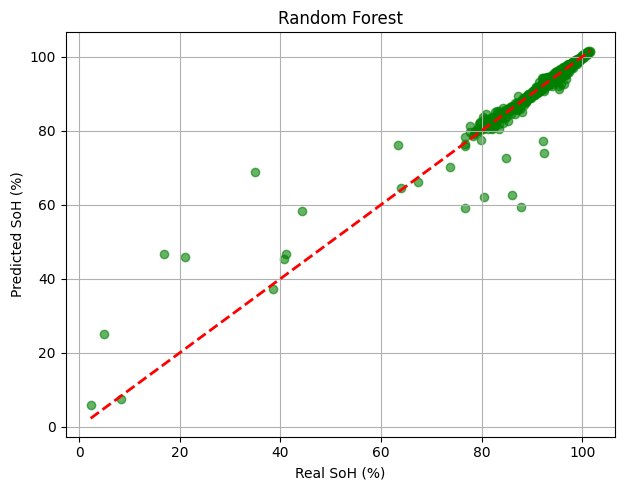

In [3]:
# Train size: 80%; Test size: 20%
cells = df["cell_id"].unique()
train_cells, test_cells = train_test_split(cells, test_size=0.2, random_state=42)

# Creating X and Y test/train 
train_df = df[df["cell_id"].isin(train_cells)]
test_df = df[df["cell_id"].isin(test_cells)]
X_train = train_df.drop(columns=["SoH", "cell_id"])
y_train = train_df["SoH"]
X_test = test_df.drop(columns=["SoH", "cell_id"])
y_test = test_df["SoH"]

# Train model and show results
RFmodel(X_train, y_train, X_test, y_test)